<a href="https://colab.research.google.com/github/beenleliu/Paddle/blob/master/Chapter_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**线性回归**

In [3]:
pip install mxnet

     |████████████████████████████████| 54.7MB 75kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [15]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

In [4]:
#矢量计算表达式
from mxnet import nd
from time import time

a = nd.ones(shape=1000)
b = nd.ones(shape=1000)

In [5]:
#标量相加消耗时间
start = time()

c = nd.zeros(shape=1000)
for i in range(1000):
  c[i] = a[i] + b[i]
time() - start

0.35286426544189453

In [6]:
#矢量相加
start = time()
d = a + b
time() - start

0.0006725788116455078

**线性回归的从零开始实现**

设训练数据集样本数为1000，输⼊个数（特征数）为2。给定随机⽣成的批量样本特
征X ∈ R
1000×2，我们使⽤线性回归模型真实权重w = [2, −3.4]⊤和偏差b = 4.2，以及⼀个随机噪
声项ϵ来⽣成标签
y = Xw + b + ϵ,
其中噪声项ϵ服从均值为0、标准差为0.01的正态分布。

In [45]:
X = nd.random.normal(scale=1, shape=(3,2))
print(X)
X[:,0]


[[0.02482807 0.00955429]
 [1.8973863  0.07713585]
 [0.40762472 0.8238177 ]]
<NDArray 3x2 @cpu(0)>



[0.02482807 1.8973863  0.40762472]
<NDArray 3 @cpu(0)>

In [7]:
#生成数据集
num_inputs = 2 #输入特征值
num_example = 1000 #1000个数据样本
true_w = [2, -3.4] #weight
true_b = 4.2 #bias
features = nd.random.normal(scale=1, shape=(num_example, num_inputs)) #随机生成1000*2的矩阵
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [13]:
features[0],labels[0]

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>, 
 [6.000587]
 <NDArray 1 @cpu(0)>)

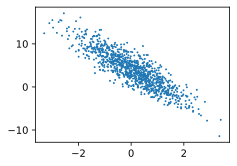

In [18]:
#生成第二个特征features[:,1]和标签labels的散点图
def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:,1].asnumpy(), labels.asnumpy(), 1); #加分号只显示图

In [21]:
#读取数据集
#我们需要遍历数据集并不断读取小批量数据样本。这⾥我们定义⼀个函数：它每次返回batch_size（批量⼤小）个随机样本的特征和标签。
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples)) #features的索引
  random.shuffle(indices) #样本读取顺序随机（随机取索引）
  for i in range(0, num_examples, batch_size):
    j = nd.array(indices[i: min(i + batch_size, num_examples)])
    yield features.take(j), labels.take(j) #take函数根据索引返回对应元素

In [22]:
#每个批量的特征形状为(10, 2)，即batch_size=10
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
  print(X,y)
  break


[[ 0.796254    0.572101  ]
 [-2.321787   -0.6055466 ]
 [-0.8624608  -0.4348689 ]
 [ 2.6766868   0.6325003 ]
 [-1.8385648   0.0952221 ]
 [ 0.81197935 -0.66640246]
 [ 0.43030912  0.6295902 ]
 [-0.9922541   2.34751   ]
 [ 0.6996008   0.26840162]
 [-0.33177793 -0.99060804]]
<NDArray 10x2 @cpu(0)> 
[ 3.8454049   1.6192857   3.9542494   7.3999124   0.20533901  8.074238
  2.9229968  -5.7664294   4.682665    6.8792953 ]
<NDArray 10 @cpu(0)>


In [24]:
#初始化模型参数
#将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。
w = nd.random.normal(scale=0.01, shape=(num_inputs,1))
b = nd.zeros(shape=(1,))
#要对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度
w.attach_grad()
b.attach_grad()

In [25]:
#定义模型
def linreg(X,w,b):
  return nd.dot(X,w) + b

In [26]:
#定义损失模型
def squared_loss(y_hat, y):
  return (y_hat - y.reshape(y_hat.shape)) **2 / 2 #均方差

In [27]:
#定义优化算法
#小批量随机梯度下降算法，不断迭代模型参数来优化损失函数。这⾥⾃动求梯度模块计算得来的梯度是⼀个批量样本的梯度和
#lr:学习率
def sgd(params, lr, batch_size):
  for param in params:
    param[:] = param - lr * param.grad/batch_size #平均值

In [28]:
#训练模型
lr = 0.03 #学习率
num_epochs = 3 #迭代周期
net = linreg
loss = squared_loss

for epoch in range(num_epochs): #训练模型一共需要num_epochs个迭代周期
  #在每⼀个迭代周期中，会使⽤训练数据集中所有样本⼀次（假设样本数能够被批量⼤⼩整除）。
  #x和y分别是小批量样本的特征和标签
  for X,y in data_iter(batch_size,features,labels):
    with autograd.record():
      l = loss(net(X,w,b), y) #l是有关⼩批量X和y的损失
    l.backward() # ⼩批量的损失对模型参数求梯度 
    sgd([w,b],lr,batch_size) # 使⽤⼩批量随机梯度下降迭代模型参数
  train_l = loss(net(features,w,b),labels)
  print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.040919
epoch 2, loss 0.000161
epoch 3, loss 0.000050


In [30]:
true_w,w

([2, -3.4], 
 [[ 1.9999537]
  [-3.3998117]]
 <NDArray 2x1 @cpu(0)>)

In [32]:
true_b,b

(4.2, 
 [4.1998215]
 <NDArray 1 @cpu(0)>)